<a href="https://colab.research.google.com/github/mwmlo/sae-qaf/blob/main/sae_qaf_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Load imports and SpArX package.

In [ ]:
!git clone https://github.com/SpArX-Group-10/SpArX

fatal: destination path 'SpArX' already exists and is not an empty directory.


In [ ]:
!pip install -q keras~=2.10 tensorflow
!pip install -q sae-lens transformer-lens

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from SpArX.sparx import FFNN, KMeansClusterer, GlobalMerger, LocalMerger

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

from transformer_lens.utils import tokenize_and_concatenate
from sae_lens import SAE

# Experiment

### Load transformer model and extract MLP of middle layer

In [ ]:
model = HookedTransformer.from_pretrained("gpt2-small", fold_ln=True)

layer_index = 6
location = "mlp_post_act"
transformer_lens_loc = f"blocks.{layer_index}.mlp.hook_post"
prev_layer_loc = f"blocks.{layer_index}.ln2.hook_normalized"

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
# Extract the nth transformer layer's MLP as a separate MLP
W_in = model.W_in[layer_index].detach().numpy()
b_in = model.b_in[layer_index].detach().numpy()
W_out = model.W_out[layer_index].detach().numpy()
b_out = model.b_out[layer_index].detach().numpy()

nx, nf = W_in.shape[0], W_in.shape[1]

intermediate_layer = Dense(units=nf, activation="gelu")
intermediate_layer.build((None, nx))
intermediate_layer.set_weights([W_in, b_in])

output_layer = Dense(units=nx)
output_layer.build((nx, nf))
output_layer.set_weights([W_out, b_out])

mlp = Sequential([
    intermediate_layer,
    output_layer
])
mlp.build((None, nx))

# Freeze the layers
for layer in mlp.layers:
    layer.trainable = False

mlp.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_170 (Dense)           (None, 3072)              2362368   
                                                                 
 dense_171 (Dense)           (None, 768)               2360064   
                                                                 
Total params: 4722432 (18.01 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 4722432 (18.01 MB)
_________________________________________________________________


In [ ]:
# Verify activation function is gelu
print(model.blocks[layer_index].mlp.act_fn)

<function gelu_new at 0x7a569b655750>


### Run SpArX on MLP target layer, using local explanations

In [ ]:
# We take a few random samples from the Pile. Each sample has about 1000 tokens.
# ds = load_dataset("NeelNanda/pile-10k", split='train').shuffle()
# # Take a small sample (otherwise session crashes from using too much RAM)
# ds_text = ds['text'][:2]
# print(ds_text)
# ds_tokens = model.to_tokens(prompt)
# ds_logits, ds_cache = model.run_with_cache(ds_tokens)

prompt = "london"
tokens = model.to_tokens(prompt)
logits, cache = model.run_with_cache(tokens)

In [ ]:
# ds_acts = ds_cache[prev_layer_loc]
# ds_acts = ds_acts.numpy().reshape(-1, 768)
# print(ds_acts.shape)

# Take 1st batch of inputs (only one input)
input_activations = cache[prev_layer_loc].numpy().reshape(-1, 768)
print(input_activations.shape)

shape = (768, 768*4, 768)
weights = [layer.get_weights()[0] for layer in mlp.layers]
bias = [layer.get_weights()[1] for layer in mlp.layers]
activations = ["gelu", "linear"]

restored_model = FFNN(shape, weights, bias, activations)
restored_model.forward_pass(input_activations)

restored_model.model.summary()

(3, 768)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 3072)              2362368   
                                                                 
 dense_173 (Dense)           (None, 768)               2360064   
                                                                 
Total params: 4722432 (18.01 MB)
Trainable params: 4722432 (18.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def shrink_model(original_model, shrink_percentage):
  cluster_labels = KMeansClusterer.cluster(original_model, shrink_percentage, seed=2025)
  # We cluster according to local activations
  merged_model = LocalMerger.merge(original_model, cluster_labels)
  return merged_model, cluster_labels

shrink_pcs = [0.1, 0.3, 0.5, 0.7, 0.9]
merged_models = []
models_cluster_labels = []
for pc in shrink_pcs:
  sparse_model, labels = shrink_model(restored_model, pc)
  sparse_model.model.summary()
  merged_models.append(sparse_model)
  models_cluster_labels.append(labels)

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 308)               236852    
                                                                 
 dense_197 (Dense)           (None, 768)               237312    
                                                                 
Total params: 474164 (1.81 MB)
Trainable params: 474164 (1.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_199 (Dense)           (None, 922)               709018    
                                                                 
 dense_200 (Dense)           (None, 768)               708864    
                                                            

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2132) found smaller than n_clusters (2151). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_205 (Dense)           (None, 2132)              1639508   
                                                                 
 dense_206 (Dense)           (None, 768)               1638144   
                                                                 
Total params: 3277652 (12.50 MB)
Trainable params: 3277652 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2490) found smaller than n_clusters (2765). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_208 (Dense)           (None, 2490)              1914810   
                                                                 
 dense_209 (Dense)           (None, 768)               1913088   
                                                                 
Total params: 3827898 (14.60 MB)
Trainable params: 3827898 (14.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Check infidelity and correlation

Under local merging, the merged models are significantly less faithful to the original model than under global merging.

In [ ]:
def output_infidelity(x, y):
    return np.linalg.norm(x - y)/len(x)

def output_mse(x, y):
  return ((x - y)**2).mean()

def output_r2(x, y):
  return 1 - (((x-y)**2).mean() / np.var(y))

# check fidelity and error (MSE)
datapoint_input = input_activations[1].reshape(1, 768)
restored_model.forward_pass(datapoint_input)
original_output = restored_model.forward_pass_data[-1]

for i, merged_model in enumerate(merged_models):
  print(f"Sparsified to {shrink_pcs[i]} of original model")

  merged_model.forward_pass(datapoint_input)
  merged_output = merged_model.forward_pass_data[-1]

  print(f"infidelity: {output_infidelity(original_output, merged_output)}")
  print(f"MSE error: {output_mse(original_output, merged_output)}")
  print(f"R2: {output_r2(original_output, merged_output)}\n")


print(f"Sanity check: infidelity between original model and original model should be 0, is {output_infidelity(original_output, original_output)}")

Sparsified to 0.1 of original model
infidelity: 7.1201202445081435e-06
MSE error: 6.601055829334387e-14
R2: 0.9999999999998549

Sparsified to 0.3 of original model
infidelity: 7.893895599409007e-06
MSE error: 8.113748252913319e-14
R2: 0.9999999999998216

Sparsified to 0.5 of original model
infidelity: 1.0122938874701504e-05
MSE error: 1.3342954941885504e-13
R2: 0.9999999999997067

Sparsified to 0.7 of original model
infidelity: 1.0567081517365295e-05
MSE error: 1.4539480459440507e-13
R2: 0.9999999999996804

Sparsified to 0.9 of original model
infidelity: 1.0715988537413068e-05
MSE error: 1.49521372930575e-13
R2: 0.9999999999996713

Sanity check: infidelity between original model and original model should be 0, is 0.0


## Run pretrained SAE on MLP hidden layer

In [ ]:
!pip install -q torch git+https://github.com/openai/sparse_autoencoder.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 832.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sae-lens 5.3.3 requires transformer-lens<3.0.0,>=2.0.0, but you have transformer-lens 1.9.1 which is incompatible.
automated-interpretability 0.0.6 requires blobfile<3.0.0,>=2.1.1, but you have blobfile 2.0.2 whi

In [ ]:
import torch

# Handle dependency issue
torch.onnx._CAFFE2_ATEN_FALLBACK = False

import sparse_autoencoder
import blobfile as bf

with bf.BlobFile(sparse_autoencoder.paths.v4(location, layer_index), mode="rb") as f:
    state_dict = torch.load(f)
    autoencoder = sparse_autoencoder.Autoencoder.from_state_dict(state_dict)

<ipython-input-45-9b873578aebf>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
# check reconstruction error
# ds_acts = ds_cache[transformer_lens_loc]
# ds_acts = ds_acts.numpy().reshape(-1, 768*4)
# print(ds_acts.shape)
# ds_acts = torch.from_numpy(ds_acts)

hidden_activations = cache[transformer_lens_loc].numpy().reshape(-1, 768*4)
print(hidden_activations.shape)
hidden_activations = torch.from_numpy(hidden_activations)

with torch.no_grad():
  latents, info = autoencoder.encode(hidden_activations)
  reconstructed_acts = autoencoder.decode(latents, info)

latents = latents.detach().numpy()
reconstructed_acts = reconstructed_acts.detach().numpy()

print("Reconstruction error for sparse autoencoder\n")

print(f"infidelity: {output_infidelity(hidden_activations, reconstructed_acts)}")
print(f"MSE error: {output_mse(hidden_activations, reconstructed_acts)}")
print(f"R2: {output_r2(hidden_activations, reconstructed_acts)}")

(3, 3072)
Reconstruction error for sparse autoencoder

infidelity: 1.4936723709106445
MSE error: 0.0021787669975310564
R2: 0.9221100807189941


### Identify max activating latent features

In [ ]:
!pip install expecttest

In [ ]:
import requests

def get_latent_features(base_activation, sae):
  # For now we focus on the word "know" (index 4)
  latents, _ = sae.encode(base_activation[-1])

  # Get list of active latent features and order by latent scores
  latent_idxs = torch.nonzero(latents).flatten()
  latent_acts = latents[latent_idxs]

  # latent_acts = latent_acts.detach().numpy()
  # latent_idxs = latent_idxs.detach().numpy()

  acts_idxs = sorted(zip(latent_acts, latent_idxs), key=lambda x: x[0], reverse=True)
  return acts_idxs

  # unique_acts_idxs = []
  # unique_idxs = set()
  # for act, idx in acts_idxs:
  #   if idx[1] not in unique_idxs:
  #     unique_acts_idxs.append((act, idx))
  #     unique_idxs.add(idx[1])

  # return unzique_acts_idxs


def get_explanations(feature_index):
  url = f"https://www.neuronpedia.org/api/feature/gpt2-small/{layer_index}-mlp-oai/{feature_index}"
  headers = {
    'Accept': 'application/json',
    'x-api-key' : "sk-np-Scp9TkTw71M2JcbNeVXDxMF3081GBnf8YY0wtKgAkf00"
  }
  try:
    response = requests.get(url, headers=headers)
  except:
    return [], []

  response = response.json()
  descriptions = []
  explanations = response.get('explanations')
  for e in explanations:
    descriptions.append(e['description'])

  # Get top three activating samples
  tokens = []
  top_samples = response.get('activations')[:5]
  for sample in top_samples:
    max_value_token_index = sample['maxValueTokenIndex']
    tokens.append(sample['tokens'][max_value_token_index])

  return descriptions, tokens

In [ ]:
def activated_cluster_neurons(cluster_labels, cluster_idx, activation_cache):
  local_activation = activation_cache[transformer_lens_loc][0].detach().clone()
  mask_neuron_idxs = list(np.where(cluster_labels != cluster_idx)[0])
  local_activation[:, mask_neuron_idxs] = 0.0
  return local_activation

# Analysis

## Measure average similarity between clusters

In [ ]:
# Get map of cluster index -> list of top 5 latent feature indices
def get_cluster_latents(merged_model, cluster_labels, activation_cache):
  cluster_latents = {}

  for n in range(num_clusters):
    acts = activated_cluster_neurons(cluster_labels[0], n, activation_cache)
    acts_idxs = get_latent_features(acts, autoencoder)[:5]
    # Collect all latent feature indices (idx) over all tokens
    idxs = [act_idx[1] for act_idx in acts_idxs]
    cluster_latents[n] = idxs

  return cluster_latents

In [ ]:
def calculate_similarity(latents_a, latents_b):
    # Convert lists to sets to find unique elements
    set_a = set(latents_a)
    set_b = set(latents_b)

    # Find shared elements
    shared_elements = set_a.intersection(set_b)
    num_shared = len(shared_elements)

    total = len(set_a) + len(set_b)
    similarity = (2 * num_shared) / total

    return similarity

In [ ]:
def get_cluster_similarity_matrix(num_clusters, cluster_latents):
  cluster_sim = np.zeros((num_clusters, num_clusters))
  for i in range(num_clusters):
    for j in range(i, num_clusters):
      similarity_score = calculate_similarity(cluster_latents[i], cluster_latents[j])
      cluster_sim[i][j] = similarity_score
      cluster_sim[j][i] = similarity_score
  return cluster_sim

In [ ]:
import matplotlib.pyplot as plt

def plot_cluster_similarity_matrix(sim_matrix):
  # Plotting the heatmap using matplotlib
  plt.figure(figsize=(8, 6))
  plt.imshow(sim_matrix, cmap='coolwarm', interpolation='nearest')
  plt.colorbar(label='Similarity Score')

  plt.title('Similarity Scores Heatmap')
  plt.xlabel('Clusters')
  plt.ylabel('Clusters')
  plt.show()

For local explanations, the average similarity increases as the number of clusters increases. This matches the trend for global explanations. However, the similarity scores are much smaller than for global explanations.

In [ ]:
sim_matrices = []

for model, labels in zip(merged_models, models_cluster_labels):
  print(f"Average similarity for sparsity {shrink_pcs[len(sim_matrices)]}")

  merged_w_in = model.model.get_weights()[0]
  num_clusters = merged_w_in.shape[1]
  # Get map of cluster index to list of latent feature indices for that cluster
  cluster_latents = get_cluster_latents(model, labels, cache)
  # Build a matrix comparing proportion of shared latent concepts between every cluster
  cluster_sim = get_cluster_similarity_matrix(num_clusters, cluster_latents)
  sim_matrices.append(cluster_sim)
  average_similarity_score = np.mean(cluster_sim)
  print(average_similarity_score)

Average similarity for sparsity 0.1
0.003246753246753247
Average similarity for sparsity 0.3
0.0010845986984815619
Average similarity for sparsity 0.5
0.0006510416666666666
Average similarity for sparsity 0.7
0.00046904315196998124
Average similarity for sparsity 0.9
0.00040160642570281126


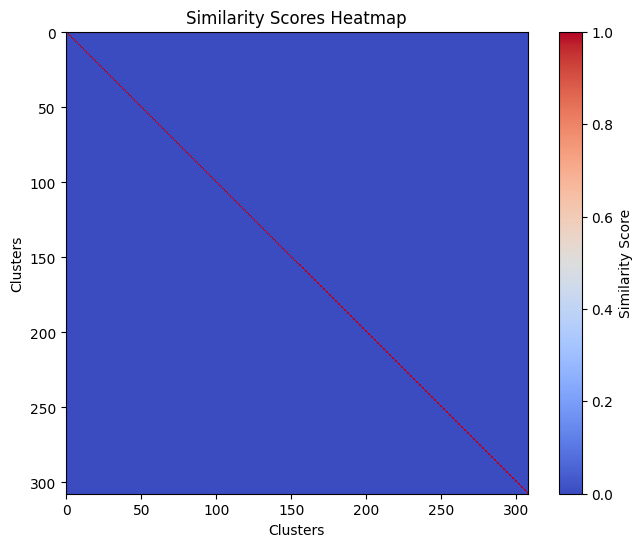

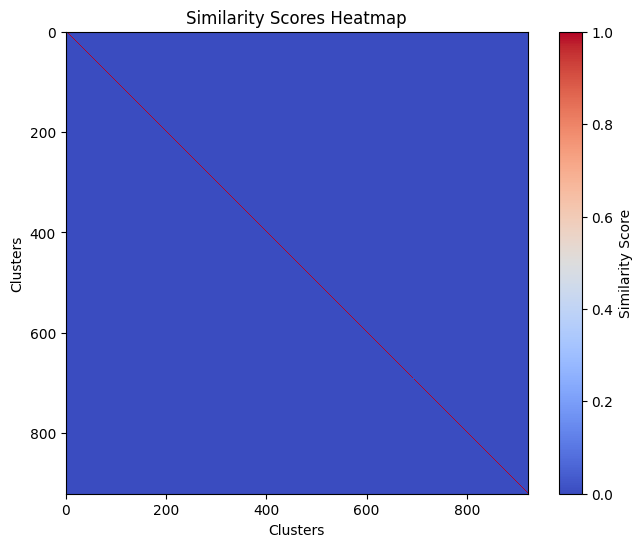

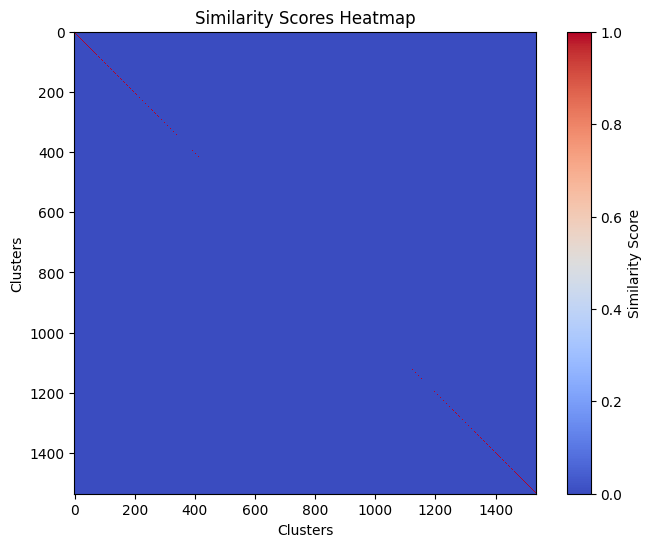

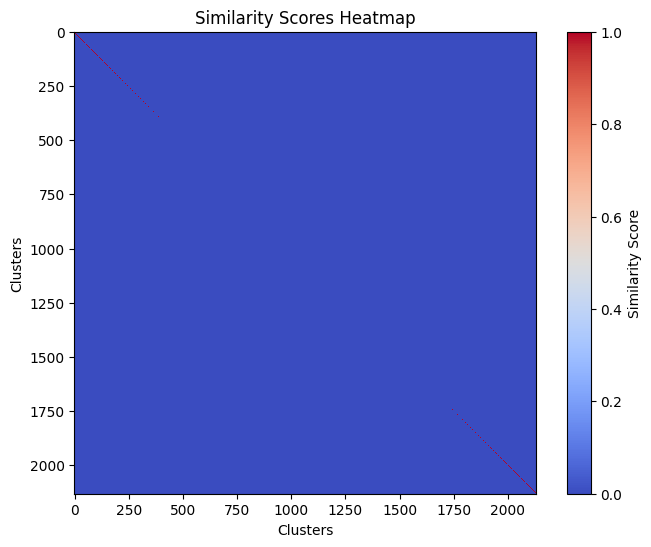

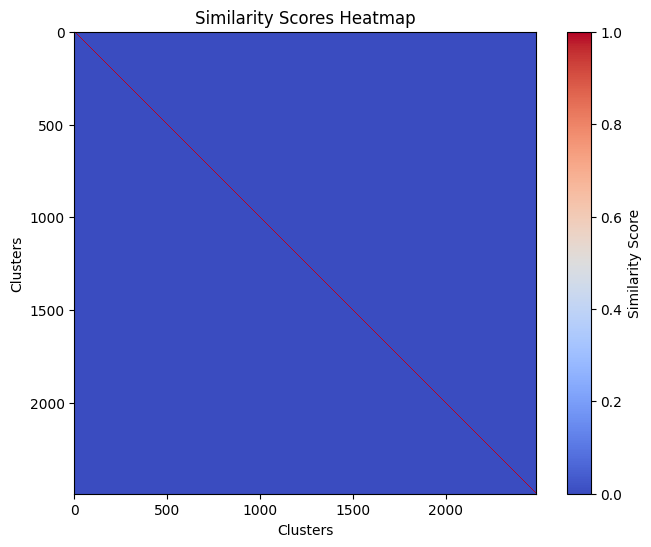

In [ ]:
for sim_matrix in sim_matrices:
  plot_cluster_similarity_matrix(sim_matrix)

## Qualitative: look at latent concepts for a few clusters

In [ ]:
print("Latents for max activation patterns for each cluster (first ten clusters) - sparsified to 10%")

# Activate neurons in original MLP which belong to the same cluster
cluster_labels_10 = models_cluster_labels[0]
for n in range(10):
# for n in range(10):
  acts = activated_cluster_neurons(cluster_labels_10[0], n, cache)
  acts_idxs = get_latent_features(acts, autoencoder)[:5]
  print(acts_idxs)
  print(f"==CLUSTER {n}==")
  for act, idx in acts_idxs:
    # act = act_idx[0]
    # idx = act_idx[1]
    descriptions, max_tokens = get_explanations(idx)
    print(f"Latent feature {idx.item()}: {round(act.item(), 3)} {descriptions}")

    print(max_tokens)

    print("---")

Latents for max activation patterns for each cluster (first ten clusters) - sparsified to 10%
[(tensor(0.0617, grad_fn=<UnbindBackward0>), tensor(3171)), (tensor(0.0589, grad_fn=<UnbindBackward0>), tensor(102)), (tensor(0.0155, grad_fn=<UnbindBackward0>), tensor(1136)), (tensor(0.0140, grad_fn=<UnbindBackward0>), tensor(83)), (tensor(0.0128, grad_fn=<UnbindBackward0>), tensor(364))]
==CLUSTER 0==
Latent feature 3171: 0.062 []
[' Co', '\n', '\n', '\n', ' Co']
---
Latent feature 102: 0.059 []
[' most', 'ronic', ' were', ' provide', 'ifact']
---
Latent feature 1136: 0.015 []
[' as', ' utmost', ' applied', ' best', ' to']
---
Latent feature 83: 0.014 []
['\n', '\n', ' are', ' simple', ' be']
---
Latent feature 364: 0.013 []
['og', 'off', ' all', 'vis', ' subsequent']
---
[(tensor(0.0632, grad_fn=<UnbindBackward0>), tensor(3171)), (tensor(0.0570, grad_fn=<UnbindBackward0>), tensor(102)), (tensor(0.0130, grad_fn=<UnbindBackward0>), tensor(364)), (tensor(0.0127, grad_fn=<UnbindBackward0>), te

In [ ]:
print("Latents for max activation patterns for each cluster (with explanations) - 10%")
w_in, b_in, w_out, b_out = merged_models[0].model.get_weights()
num_clusters = w_out.shape[0]

# Activate neurons in original MLP which belong to the same cluster
cluster_labels_10 = models_cluster_labels[0]
for n in range(num_clusters):
# for n in range(10):
  acts = activated_cluster_neurons(cluster_labels_10[0], n, cache)
  acts_idxs = get_latent_features(acts, autoencoder)[:5]
  print(f"==CLUSTER {n}==")
  for act, idx in acts_idxs:
    descriptions, max_tokens = get_explanations(idx)

    # Ignore those without existing descriptions
    if len(descriptions) == 0:
      continue

    print(f"Latent feature {idx.item()}: {round(act.item(), 3)}")
    print(f"{descriptions}")

    # for t in max_tokens:
    #   print(t)

    print("---")

# 38 clusters with explanations / 922 = 4.1%

Latents for max activation patterns for each cluster (with explanations) - 10%
torch.Size([17])
==CLUSTER 0==
torch.Size([17])
==CLUSTER 1==
torch.Size([17])
==CLUSTER 2==
torch.Size([16])
==CLUSTER 3==
torch.Size([18])
==CLUSTER 4==
torch.Size([19])
==CLUSTER 5==
torch.Size([19])
==CLUSTER 6==
torch.Size([18])
==CLUSTER 7==
torch.Size([18])
==CLUSTER 8==
torch.Size([17])
==CLUSTER 9==
torch.Size([17])
==CLUSTER 10==
torch.Size([8])
==CLUSTER 11==
torch.Size([17])
==CLUSTER 12==
torch.Size([17])
==CLUSTER 13==
torch.Size([17])
==CLUSTER 14==
torch.Size([23])
==CLUSTER 15==
torch.Size([17])
==CLUSTER 16==
torch.Size([17])
==CLUSTER 17==
torch.Size([17])
==CLUSTER 18==
torch.Size([16])
==CLUSTER 19==
torch.Size([26])
==CLUSTER 20==
Latent feature 2411: 0.029
['sentences about football (soccer)', ' references to names of individuals, particularly athletes or public figures, often in a sports context']
---
torch.Size([17])
==CLUSTER 21==
torch.Size([17])
==CLUSTER 22==
torch.Size([20])
==C

## How do activations for SAE latents map onto SpArX clusters?

It seems that activations for SAE latents are highly distributed over SpArX clusters.

In [ ]:
KNOW_LATENT_INDEX = 24106 # https://www.neuronpedia.org/gpt2-small/6-mlp-oai/24106
KNOW_LATENT_INDICES = [24106, 25303, 21772, 22595, 21028, 20313, 21672]
num_latents = autoencoder.encoder.out_features

In [ ]:
know_latent_activation = torch.zeros(num_latents)
know_latent_activation[KNOW_LATENT_INDICES] = 1
reconstructed_acts_1 = autoencoder.decode(know_latent_activation)
print(reconstructed_acts_1.shape)

decoder_weights = autoencoder.decoder.state_dict()['weight']
mul_acts = torch.index_select(decoder_weights, -1, torch.tensor(KNOW_LATENT_INDICES))
print(mul_acts.shape)
reconstructed_acts_2 = torch.amax(mul_acts, dim=1)
print(reconstructed_acts_2.shape)

hidden_activations = cache[transformer_lens_loc].numpy().reshape(-1, 768*4)
hidden_activations = torch.from_numpy(hidden_activations)[-1] # Focus on last token

with torch.no_grad():
  x, info = autoencoder.preprocess(hidden_activations)
  preactivations = autoencoder.encode_pre_act(x)
  mult_acts = autoencoder.activation(preactivations)

  mask = torch.zeros(preactivations.shape)
  mask[KNOW_LATENT_INDICES] = 1
  swap_lats = torch.mul(preactivations, mask)
  print(swap_lats.shape)
  reconstructed_acts_3 = autoencoder.decode(swap_lats, info)



# activations_lats = torch.multiply(preactivations, scores).type(torch.FloatTensor)
#         mult_acts = sae.activation(activations_lats)
#         mask = torch.zeros(1, preactivations.size(1), preactivations.size(2))
#         mask[torch.nonzero(mult_acts, as_tuple=True)] = 1
#         swap_lats = torch.mul(preactivations, mask.to(device))
#         swap_activations = sae.decode(swap_lats, info2)
print(reconstructed_acts_3.shape)

torch.Size([3072])
torch.Size([3072, 7])
torch.Size([3072])
torch.Size([32768])
torch.Size([3072])
torch.Size([3072])


In [ ]:
# This is the right way of doing things
reconstructed_acts = autoencoder.decoder.state_dict()['weight'][:, KNOW_LATENT_INDEX]

In [ ]:
print(reconstructed_acts.shape)

get_explanations(KNOW_LATENT_INDEX)

torch.Size([3072])


([" the word 'know'"], [' know', ' know', ' know', ' know', ' know'])

## Check: does encoding the reconstructed activations get back to the original SAE latent feature? It doesn't look like it!

In [ ]:
def list_explanations_for_single_activation(activation):
  activation = torch.unsqueeze(activation, dim=0)
  with torch.no_grad():
    exps = get_latent_features(activation, autoencoder)

  print(KNOW_LATENT_INDEX in [ai[1] for ai in exps])

  for act_idx in exps[:5]:
    act = act_idx[0]
    idx = act_idx[1]
    descriptions, max_tokens = get_explanations(idx)

    print(f"Latent feature {idx.item()}: {round(act.item(), 3)}, {descriptions}")

    print(max_tokens)

    print("---")

In [ ]:
og_model = HookedTransformer.from_pretrained("gpt2-small", center_writing_weights=False)
prompt = "I want to know"
tokens = model.to_tokens(prompt)
logits, cache = model.run_with_cache(tokens)

hidden_activations = cache[transformer_lens_loc].numpy().reshape(-1, 768*4)
hidden_activations = torch.from_numpy(hidden_activations)

for act in hidden_activations:
  list_explanations_for_single_activation(act)

  # reconstructed = autoencoder.decode(autoencoder.encode(act)[0])
  # list_explanations_for_single_activation(reconstructed)

Loaded pretrained model gpt2-small into HookedTransformer
torch.Size([2])
False
Latent feature 3171: 0.678, []
[' Co', '\n', '\n', '\n', ' Co']
---
Latent feature 3442: 0.488, []
['have', ' the', ' were', 'read', ' the']
---
torch.Size([80])
False
Latent feature 10089: 0.312, []
[' signed', ' signed', ' took', ' contributed', ' wrote']
---
Latent feature 3574: 0.124, []
[' Future', ' star', 'ide', 'IA', 'ity']
---
Latent feature 9807: 0.101, []
[' suites', ' studies', 'ills', ' plays', "'s"]
---
Latent feature 2412: 0.09, []
[' or', ' saw', ' from', ' behind', ' of']
---
Latent feature 8723: 0.071, []
['\n', '\n', '\n', '\n', '\n']
---
torch.Size([121])
False
Latent feature 11598: 0.434, []
['AT', 'At', 'CON', 'DES', 'Ex']
---
Latent feature 12668: 0.177, []
[' and', ' and', ' and', ' and', ' and']
---
Latent feature 7350: 0.083, []
[' was', ' was', ' were', ' was', ' was']
---
Latent feature 2412: 0.076, []
[' or', ' saw', ' from', ' behind', ' of']
---
Latent feature 5143: 0.074, []


In [ ]:
list_explanations_for_single_activation(reconstructed_acts_1)

torch.Size([2855])
False
Latent feature 7152: 0.2, []
['.', '.', '.', '.', '.']
---
Latent feature 14463: 0.177, []
[' and', ' and', ' and', ' and', ' and']
---
Latent feature 6180: 0.167, []
[' Air', ' Air', ' Air', ' breathe', 'Earth']
---
Latent feature 162: 0.144, []
[' τ', 'Sc', 'mine', ' 8', ' ->']
---
Latent feature 7172: 0.143, []
['mail', ' fever', ' testing', ' bid', ' description']
---


In [ ]:
list_explanations_for_single_activation(reconstructed_acts_2)

torch.Size([62])
False
Latent feature 3171: 0.298, []
[' Co', '\n', '\n', '\n', ' Co']
---
Latent feature 98: 0.173, []
['=', 'agg', ':', '=', 'ogg']
---
Latent feature 771: 0.132, []
['pos', ' periods', ' field', 'bb', ' understanding']
---
Latent feature 2: 0.106, []
[',', ',', ',', ' -', '"']
---
Latent feature 53: 0.097, []
["'", ' needs', ' popped', ' bill', ' devoted']
---


In [ ]:
list_explanations_for_single_activation(reconstructed_acts_3)

torch.Size([0])
False


In [ ]:
import torch.optim as optim

# Initialize latent activation with zeros
input_data = torch.randn(768*4, requires_grad=True)

# Define optimizer
optimizer = optim.Adam([input_data], lr=0.05)

# Define the number of iterations for optimization
num_iterations = 500

# Optimization loop to find the input that activates the target latent feature
for _ in range(num_iterations):
    optimizer.zero_grad()

    # Forward pass through the autoencoder
    encoded = autoencoder.encode(input_data)[0]

    # Extract the latent activation for the specified index
    latent_activation = encoded[KNOW_LATENT_INDEX]

    # Define a loss function to maximize the activation of the latent feature
    loss = -latent_activation  # Negative to maximize the activation

    loss.backward()
    optimizer.step()

# Get the optimized input
optimized_input = input_data.detach()

print("Optimized input that emphasizes the latent feature:", optimized_input.shape)

list_explanations_for_single_activation(optimized_input)

Optimized input that emphasizes the latent feature: torch.Size([3072])
torch.Size([6281])
False
Latent feature 9058: 0.45, []
[' web', ' web', ' web', ' television', ' web']
---
Latent feature 15985: 0.423, []
[' I', ' I', ' I', ' I', ' I']
---
Latent feature 11055: 0.361, []
[' with', ' with', ' with', ' with', ' accompany']
---
Latent feature 14456: 0.356, []
[' next', ' next', ' first', ' next', ' first']
---
Latent feature 15992: 0.347, []
[' Sgt', ' Sgt', ' Sgt', ' Sgt', ' Sgt']
---


## Check: does activating all of the neurons in these clusters lead to any meaningful latent concept being activated? Not really.

In [ ]:
from collections import Counter

def get_activated_clusters(activations, cluster_labels):
  # Assume activations is 1D tensor
  active_neurons = np.where(abs(activations) > 0.5)
  print(active_neurons)
  active_clusters = [cluster_labels[n] for n in active_neurons]
  return Counter(active_clusters[0])

cluster_count = get_activated_clusters(reconstructed_acts, models_cluster_labels[0][0])
print(cluster_count)

(array([  69,  175,  180,  234,  269,  315,  337,  361,  363,  437,  497,
        517,  546,  578,  689,  718,  834,  897, 1165, 1360, 1532, 1562,
       1687, 1820, 1829, 1959, 1975, 1980, 1983, 2037, 2063, 2149, 2159,
       2178, 2321, 2356, 2377, 2445, 2541, 2613, 2653, 2668, 2805, 2924,
       3002, 3029, 3039, 3048]),)
Counter({273: 3, 110: 2, 198: 2, 145: 2, 5: 2, 173: 2, 90: 1, 0: 1, 126: 1, 166: 1, 289: 1, 302: 1, 91: 1, 230: 1, 217: 1, 168: 1, 57: 1, 193: 1, 98: 1, 234: 1, 69: 1, 96: 1, 23: 1, 244: 1, 301: 1, 256: 1, 223: 1, 58: 1, 3: 1, 178: 1, 124: 1, 8: 1, 10: 1, 54: 1, 295: 1, 255: 1, 205: 1, 229: 1, 167: 1, 117: 1, 94: 1})


In [ ]:
# sanity check: does activating these clusters get the latent feature?
active_all_know_cluster_neurons = torch.zeros(768*4)

know_cluster_idxs = list(cluster_count.keys())
for cluster_idx in list(cluster_count.keys()):
  active_neurons = activated_cluster_neurons(models_cluster_labels[0][0], cluster_idx, cache)
  active_all_know_cluster_neurons = torch.logical_or(active_all_know_cluster_neurons, active_neurons)

active_all_know_cluster_neurons = active_all_know_cluster_neurons.float()
print(torch.nonzero(active_all_know_cluster_neurons).flatten().shape)

torch.Size([863])


In [ ]:
list_explanations_for_single_activation(active_all_know_cluster_neurons)

[(tensor(0.1930), tensor(3171)), (tensor(0.1860), tensor(6388)), (tensor(0.1674), tensor(3099)), (tensor(0.1576), tensor(98)), (tensor(0.1451), tensor(771)), (tensor(0.1266), tensor(364)), (tensor(0.1195), tensor(2779)), (tensor(0.0960), tensor(7872)), (tensor(0.0909), tensor(3062)), (tensor(0.0879), tensor(3524)), (tensor(0.0866), tensor(53)), (tensor(0.0779), tensor(4678)), (tensor(0.0771), tensor(5244)), (tensor(0.0761), tensor(1580)), (tensor(0.0750), tensor(589)), (tensor(0.0726), tensor(1892)), (tensor(0.0726), tensor(4405)), (tensor(0.0723), tensor(1759)), (tensor(0.0710), tensor(155)), (tensor(0.0702), tensor(2681)), (tensor(0.0696), tensor(1148)), (tensor(0.0679), tensor(1111)), (tensor(0.0660), tensor(6434)), (tensor(0.0644), tensor(1078)), (tensor(0.0634), tensor(274)), (tensor(0.0625), tensor(2299)), (tensor(0.0619), tensor(1400)), (tensor(0.0608), tensor(2856)), (tensor(0.0608), tensor(10401)), (tensor(0.0606), tensor(1360)), (tensor(0.0596), tensor(2706)), (tensor(0.0585)

Check: does randomly picking a neuron in each of the activated clusters still get us to the original latent concept?